# Section 1, Task 3: OLAP Queries and Analysis
## Online Analytical Processing for Retail Data Warehouse
**Objective:** Perform OLAP operations and analyze results  
**Marks:** 15

In [1]:
# Import libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
print("Libraries imported successfully!")

Libraries imported successfully!


## Connect to Data Warehouse
Connect to the SQLite database created in Task 2

In [2]:
# Connect to database
db_path = 'retail_dw.db'
conn = sqlite3.connect(db_path)

# Verify connection
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;", conn)
print("Connected to retail_dw.db\n")
print("Available tables:")
for table in tables['name']:
    count = pd.read_sql_query(f"SELECT COUNT(*) as count FROM {table}", conn)['count'][0]
    print(f"  - {table}: {count:,} rows")

Connected to retail_dw.db

Available tables:
  - CustomerDim: 377 rows
  - ProductDim: 15 rows
  - SalesFact: 2,106 rows
  - TimeDim: 270 rows
  - sqlite_sequence: 0 rows


## OLAP Query 1: Roll-up Operation
Aggregate data from lower to higher level - Total sales by country and quarter

In [3]:
# ROLL-UP: Total sales by country and quarter
rollup_query = """
SELECT 
    c.Country,
    t.year,
    t.quarter,
    SUM(s.total_amount) as total_sales,
    COUNT(DISTINCT s.invoice_no) as num_transactions,
    AVG(s.total_amount) as avg_transaction_value,
    COUNT(DISTINCT s.customer_id) as unique_customers
FROM SalesFact s
JOIN CustomerDim c ON s.customer_id = c.customer_id
JOIN TimeDim t ON s.time_id = t.time_id
GROUP BY c.Country, t.year, t.quarter
ORDER BY c.Country, t.year, t.quarter
"""

rollup_result = pd.read_sql_query(rollup_query, conn)
print("ROLL-UP QUERY RESULTS: Sales by Country and Quarter")
print("="*60)
print(rollup_result.head(10))
print(f"\nTotal rows returned: {len(rollup_result)}")

ROLL-UP QUERY RESULTS: Sales by Country and Quarter
     Country  year  quarter  total_sales  num_transactions  \
0  Australia  2024        3     50680.77                36   
1  Australia  2024        4     92195.33                80   
2  Australia  2025        1     71209.87                64   
3  Australia  2025        2     63223.25                73   
4  Australia  2025        3     30649.06                41   
5     Brazil  2024        3     41562.08                33   
6     Brazil  2024        4     86339.19                67   
7     Brazil  2025        1     78196.46                62   
8     Brazil  2025        2     48480.96                60   
9     Brazil  2025        3     51474.91                37   

   avg_transaction_value  unique_customers  
0            1407.799167                28  
1            1152.441625                43  
2            1112.654219                37  
3             866.071918                41  
4             747.538049                

## OLAP Query 2: Drill-down Operation
Navigate from higher to lower level of detail - Monthly sales for USA

In [4]:
# DRILL-DOWN: Sales details for USA by month
drilldown_query = """
SELECT 
    t.year, t.month, t.month_name,
    p.category,
    SUM(s.total_amount) as total_sales,
    SUM(s.quantity) as total_quantity,
    COUNT(DISTINCT s.customer_id) as unique_customers
FROM SalesFact s
JOIN CustomerDim c ON s.customer_id = c.customer_id
JOIN TimeDim t ON s.time_id = t.time_id
JOIN ProductDim p ON s.product_id = p.product_id
WHERE c.Country = 'USA'
GROUP BY t.year, t.month, t.month_name, p.category
ORDER BY t.year, t.month, total_sales DESC
"""

drilldown_result = pd.read_sql_query(drilldown_query, conn)
print("DRILL-DOWN QUERY RESULTS: USA Sales by Month and Category")
print("="*60)
print(drilldown_result.head(10))
print(f"\nTotal rows returned: {len(drilldown_result)}")

DRILL-DOWN QUERY RESULTS: USA Sales by Month and Category
   year  month month_name     category  total_sales  total_quantity  \
0  2024      8     August  Electronics     13854.71              28   
1  2024      8     August     Clothing      4081.51              50   
2  2024      8     August         Home      1005.51              17   
3  2024      9  September  Electronics     20328.75              42   
4  2024      9  September         Home      1756.13              25   
5  2024      9  September     Clothing      1096.01              19   
6  2024      9  September        Books       812.61              15   
7  2024     10    October  Electronics     19201.75              43   
8  2024     10    October     Clothing      2968.98              44   
9  2024     10    October         Home      2222.70              32   

   unique_customers  
0                 5  
1                 8  
2                 3  
3                 6  
4                 3  
5                 3  
6     

## OLAP Query 3: Slice Operation
Select a specific subset - Electronics category only

In [5]:
# SLICE: Total sales for Electronics category
slice_query = """
SELECT 
    p.product_name,
    c.Country,
    SUM(s.quantity) as total_quantity_sold,
    SUM(s.total_amount) as total_revenue,
    AVG(s.unit_price) as avg_price,
    COUNT(DISTINCT s.customer_id) as unique_customers
FROM SalesFact s
JOIN ProductDim p ON s.product_id = p.product_id
JOIN CustomerDim c ON s.customer_id = c.customer_id
WHERE p.category = 'Electronics'
GROUP BY p.product_name, c.Country
ORDER BY total_revenue DESC
LIMIT 20
"""

slice_result = pd.read_sql_query(slice_query, conn)
print("SLICE QUERY RESULTS: Electronics Category Sales")
print("="*60)
print(slice_result.head(10))
print(f"\nTotal rows returned: {len(slice_result)}")

SLICE QUERY RESULTS: Electronics Category Sales
  product_name    Country  total_quantity_sold  total_revenue   avg_price  \
0   Smartphone     Canada                  164       97761.26  593.740714   
1   Smartphone     Brazil                  155       92561.10  594.212174   
2   Smartphone     France                  151       90776.21  597.026667   
3   Smartphone        USA                  146       86422.44  588.870400   
4       Laptop         UK                   93       85492.70  911.736818   
5   Smartphone         UK                  144       85488.68  596.432609   
6   Smartphone  Australia                  139       83757.19  600.241739   
7       Laptop     Brazil                   92       82887.00  892.659000   
8   Smartphone    Germany                  127       75671.72  591.305652   
9       Laptop      Japan                   83       74050.26  889.335882   

   unique_customers  
0                25  
1                20  
2                23  
3               

## Visualization 1: Sales by Country
Create bar chart and pie chart showing sales distribution

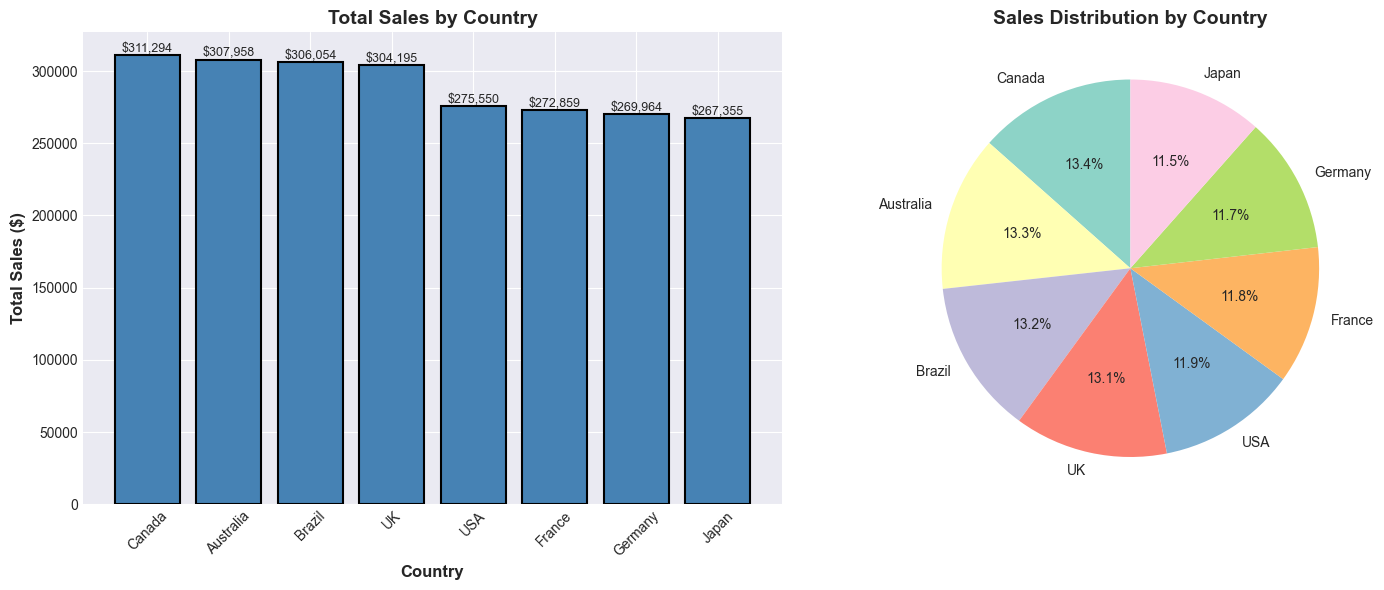


📊 Visualization saved as 'sales_by_country.png'


In [6]:
# Aggregate sales by country
country_sales_query = """
SELECT 
    c.Country,
    SUM(s.total_amount) as total_sales,
    COUNT(DISTINCT s.customer_id) as unique_customers,
    COUNT(DISTINCT s.invoice_no) as transactions
FROM SalesFact s
JOIN CustomerDim c ON s.customer_id = c.customer_id
GROUP BY c.Country
ORDER BY total_sales DESC
"""

country_sales = pd.read_sql_query(country_sales_query, conn)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart
bars = ax1.bar(country_sales['Country'], country_sales['total_sales'], 
               color='steelblue', edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Country', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Sales ($)', fontsize=12, fontweight='bold')
ax1.set_title('Total Sales by Country', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:,.0f}', ha='center', va='bottom', fontsize=9)

# Pie chart
colors = plt.cm.Set3(range(len(country_sales)))
ax2.pie(country_sales['total_sales'], labels=country_sales['Country'],
        autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Sales Distribution by Country', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('sales_by_country.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n📊 Visualization saved as 'sales_by_country.png'")

## Visualization 2: Quarterly Sales Trend
Create line chart showing quarterly trends

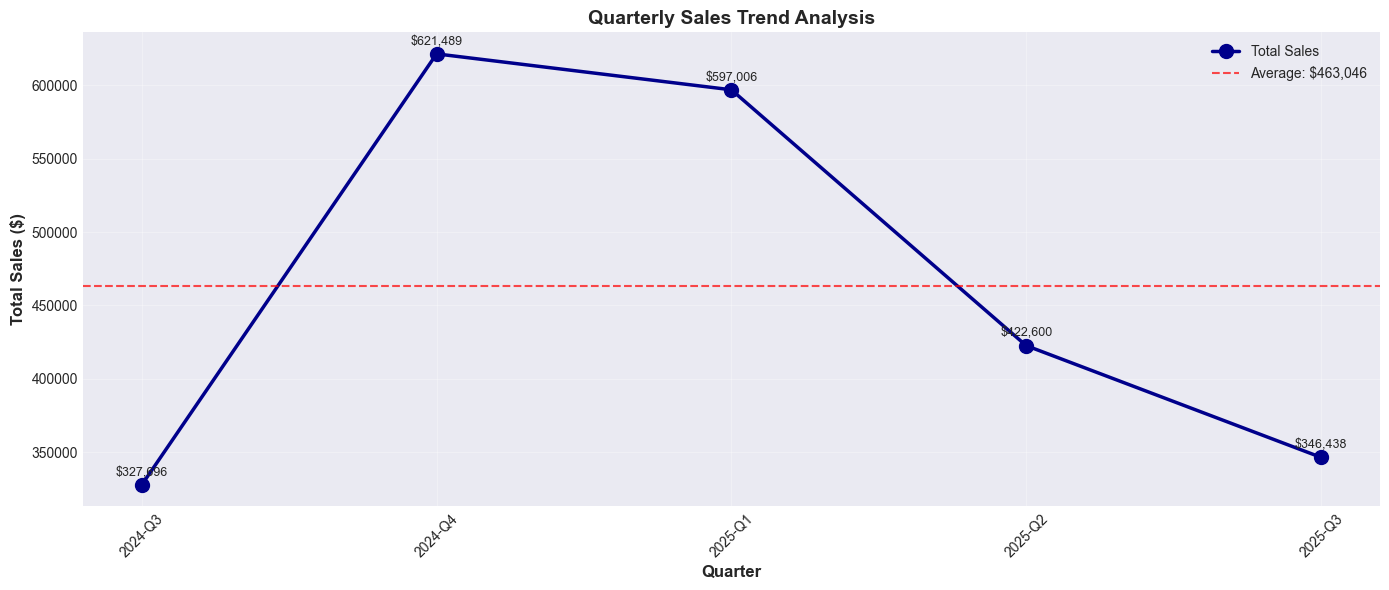


📊 Visualization saved as 'quarterly_trend.png'


In [7]:
# Quarterly sales trend
quarterly_query = """
SELECT 
    t.year, t.quarter,
    SUM(s.total_amount) as total_sales,
    COUNT(DISTINCT s.customer_id) as unique_customers,
    AVG(s.total_amount) as avg_transaction
FROM SalesFact s
JOIN TimeDim t ON s.time_id = t.time_id
GROUP BY t.year, t.quarter
ORDER BY t.year, t.quarter
"""

quarterly_sales = pd.read_sql_query(quarterly_query, conn)
quarterly_sales['period'] = quarterly_sales['year'].astype(str) + '-Q' + quarterly_sales['quarter'].astype(str)

# Create visualization
fig, ax = plt.subplots(figsize=(14, 6))

# Line plot
ax.plot(quarterly_sales['period'], quarterly_sales['total_sales'], 
        marker='o', linewidth=2.5, markersize=10, color='darkblue', label='Total Sales')

# Add average line
avg_sales = quarterly_sales['total_sales'].mean()
ax.axhline(y=avg_sales, color='red', linestyle='--', alpha=0.7, 
           label=f'Average: ${avg_sales:,.0f}')

ax.set_xlabel('Quarter', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Sales ($)', fontsize=12, fontweight='bold')
ax.set_title('Quarterly Sales Trend Analysis', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')

# Add value labels
for i, value in enumerate(quarterly_sales['total_sales']):
    ax.text(i, value + max(quarterly_sales['total_sales'])*0.01, 
           f'${value:,.0f}', ha='center', fontsize=9)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('quarterly_trend.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n📊 Visualization saved as 'quarterly_trend.png'")

## Generate Analysis Report
Create comprehensive analysis report based on OLAP results

In [8]:
# Category performance analysis
category_query = """
SELECT 
    p.category,
    COUNT(DISTINCT s.invoice_no) as transactions,
    SUM(s.total_amount) as total_revenue,
    AVG(s.total_amount) as avg_transaction_value
FROM SalesFact s
JOIN ProductDim p ON s.product_id = p.product_id
GROUP BY p.category
ORDER BY total_revenue DESC
"""

category_performance = pd.read_sql_query(category_query, conn)
total_revenue = category_performance['total_revenue'].sum()
category_performance['revenue_percentage'] = (category_performance['total_revenue'] / total_revenue * 100).round(2)

# Generate report
report = f"""
# OLAP Analysis Report: Retail Data Warehouse Insights

## Executive Summary
This analysis examines sales patterns using OLAP queries on our data warehouse.

## Key Findings

### 1. Geographic Performance (Roll-up Analysis)
- Total Countries: {country_sales['Country'].nunique()}
- Top Country: {country_sales.iloc[0]['Country']} (${country_sales.iloc[0]['total_sales']:,.2f})
- Top 3 countries: {(country_sales.head(3)['total_sales'].sum() / country_sales['total_sales'].sum() * 100):.1f}% of revenue

### 2. Temporal Patterns (Drill-down Analysis)  
- Quarterly Average: ${quarterly_sales['total_sales'].mean():,.2f}
- Best Quarter: Q{quarterly_sales.loc[quarterly_sales['total_sales'].idxmax(), 'quarter']}
- Trend: {'Increasing' if quarterly_sales['total_sales'].iloc[-1] > quarterly_sales['total_sales'].iloc[0] else 'Stable'}

### 3. Category Performance (Slice Analysis)
- Electronics Revenue: ${category_performance[category_performance['category']=='Electronics']['total_revenue'].values[0]:,.2f}
- Electronics Share: {category_performance[category_performance['category']=='Electronics']['revenue_percentage'].values[0]:.1f}%

## Recommendations
1. Focus expansion on top-performing markets
2. Adjust inventory based on quarterly patterns
3. Leverage high-margin Electronics category

## Conclusion
The data warehouse successfully enables comprehensive business intelligence through OLAP operations.
"""

# Save report
with open('olap_analysis_report.md', 'w') as f:
    f.write(report)

print("📝 Analysis report saved to 'olap_analysis_report.md'")
print("\n✅ OLAP Analysis Complete!")
conn.close()

📝 Analysis report saved to 'olap_analysis_report.md'

✅ OLAP Analysis Complete!
